In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint



In [7]:
# Path to your image dataset
#data_dir = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images'
#labels_file = '/home/gcekcse/Documents/ML_Project_hk/aptos2019-blindness-detection/G1/G1.csv'
data_dir = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/'
labels_file = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1.csv'


# Load labels
df = pd.read_csv(labels_file)



In [8]:
# Count the number of samples for each class
class_counts = df['diagnosis'].value_counts().reset_index()

# Rename the columns for better understanding
class_counts.columns = ['Class', 'Number of Samples']

# Display the tabular view
print(class_counts)

   Class  Number of Samples
0      0               1805
1      2                999
2      1                370
3      4                295
4      3                193


In [9]:
# Split data into training and testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display sample data
print(train_df.head())

           id_code  diagnosis
2181  996f9bba4ef0          0
570   286e9981dd9b          0
3389  eae70f527755          0
343   19244004583f          3
1801  7f0ffeb0a333          0


In [ ]:
'''import cv2
import os

image_directory = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images'
image_files = os.listdir(image_directory)

# Check for files
if not image_files:
    print("No files found in the specified directory.")
else:
    print(f"Found {len(image_files)} files in the directory.")

# Loop through each image file and attempt to load it
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load image at {image_path}")
        else:
            print(f"Successfully loaded image at {image_path}")
    except Exception as e:
        print(f"Exception occurred for {image_path}: {e}")

# Optionally, you can keep a list of the problematic files
problematic_files = []
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    if cv2.imread(image_path) is None:
        problematic_files.append(image_file)

print("Problematic files that could not be loaded:")
for file in problematic_files:
    print(file)
'''

'import cv2\nimport os\n\nimage_directory = \'/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images\'\nimage_files = os.listdir(image_directory)\n\n# Check for files\nif not image_files:\n    print("No files found in the specified directory.")\nelse:\n    print(f"Found {len(image_files)} files in the directory.")\n\n# Loop through each image file and attempt to load it\nfor image_file in image_files:\n    image_path = os.path.join(image_directory, image_file)\n    try:\n        image = cv2.imread(image_path)\n        if image is None:\n            print(f"Error: Unable to load image at {image_path}")\n        else:\n            print(f"Successfully loaded image at {image_path}")\n    except Exception as e:\n        print(f"Exception occurred for {image_path}: {e}")\n\n# Optionally, you can keep a list of the problematic files\nproblematic_files = []\nfor image_file in image_files:\n    image_path = os.path.join(image_directory, image_file)\n    if cv2.imread

In [6]:
import cv2
import os
import numpy as np

# Directory containing the images
image_directory = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images'
data_dir = image_directory  # You can change this if needed
IMG_SIZE = 224  # Resize images to 224x224

# Function to check and load images
def load_images(image_directory):
    image_files = os.listdir(image_directory)

    # Check for files
    if not image_files:
        print("No files found in the specified directory.")
        return [], []
    else:
        print(f"Found {len(image_files)} files in the directory.")

    # Lists to store successfully loaded images and problematic files
    loaded_images = []
    problematic_files = []

    # Loop through each image file and attempt to load it
    for image_file in image_files:
        image_path = os.path.join(image_directory, image_file)
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Unable to load image at {image_path}")
                problematic_files.append(image_file)
            else:
                print(f"Successfully loaded image at {image_path}")
                loaded_images.append((image_file, image))  # Store filename and image
        except Exception as e:
            print(f"Exception occurred for {image_path}: {e}")
            problematic_files.append(image_file)

    print("Problematic files that could not be loaded:")
    for file in problematic_files:
        print(file)

    return loaded_images, problematic_files

# Function to preprocess images
def preprocess_image(image):
    img = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize the image
    img = img / 255.0  # Normalize
    return img

def preprocess_data(dataframe, loaded_images):
    X = []
    y = []
    file_dict = {file[0]: file[1] for file in loaded_images}  # Map filenames to images

    for idx, row in dataframe.iterrows():
        img_name = row['id_code'] + ".png"  # Assuming .png extension
        if img_name in file_dict:  # Check if the image was loaded successfully
            img = preprocess_image(file_dict[img_name])  # Preprocess the image
            X.append(img)
            y.append(row['diagnosis'])  # Assuming 'diagnosis' contains the target label

        if idx % 100 == 0:  # Log progress every 100 images
            print(f"Processed {idx + 1}/{len(dataframe)} images.")

    return np.array(X), np.array(y)

# Load images
print("Loading images from directory...")
loaded_images, problematic_files = load_images(image_directory)

# Preprocess data
print("Preprocessing training data...")
X_train, y_train = preprocess_data(train_df, loaded_images)

print("Preprocessing test data...")
X_test, y_test = preprocess_data(test_df, loaded_images)

print("Preprocessing completed.")

# Define the directory where you want to save the data
save_dir = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/data/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save training data
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)

# Save test data
np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)



Loading images from directory...
Found 1216 files in the directory.
Successfully loaded image at /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/357f02a779d7.png
Successfully loaded image at /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/365f8c01d994.png
Successfully loaded image at /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/35df2bc6ae95.png
Successfully loaded image at /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/359bab5d784b.png
Successfully loaded image at /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/35cd9832fc0a.png
Successfully loaded image at /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/356304d15a5c.png
Successfully loaded image at /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/G1/G1_images/35beb47fe159.png
Successfully loaded image at /conten

KeyboardInterrupt: 

In [10]:
import numpy as np
import os

# Define the directory where your data is stored
data_dir = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/data/'

# Load data
X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

In [11]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set the image size
IMG_SIZE = 224  # Change this if your input size is different

# Load ResNet50 base model (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Assuming 5 DR severity levels
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Build the model to define all shapes
model.build((None, IMG_SIZE, IMG_SIZE, 3))  # Add this line to explicitly define the input shape

# View the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 74971013 (285.99 MB)
Trainable params: 51383301 (196.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [12]:

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Define the checkpoint callback to overwrite the saved model after each epoch
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/models/model.keras',  # Change to .keras
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Num GPUs Available:  0


In [ ]:
# Fit the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint_callback, early_stopping]
)


Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 1.3765 - accuracy: 0.7954
Epoch 1: saving model to /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/models/model.keras
30/30 [==============================] - 40s 1s/step - loss: 1.3765 - accuracy: 0.7954 - val_loss: 1.1100 - val_accuracy: 0.8157
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.8395
Epoch 2: saving model to /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/models/model.keras
30/30 [==============================] - 30s 996ms/step - loss: 0.7088 - accuracy: 0.8395 - val_loss: 0.7172 - val_accuracy: 0.8157
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.8678
Epoch 3: saving model to /content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/models/model.keras
30/30 [==============================] - 30s 1s/step - loss: 0.6025 - accuracy: 0.8678 - val_loss: 0.7150 - val_accura

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Load the model
print("Loading the model...")
#model = load_model(r'/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/models/model.keras')

# Define the directory where your data is stored
data_dir = '/content/drive/MyDrive/Hemant/Projects/aptos2019-blindness-detection/data/'

# Step 2: Load the test data
print("Loading test data...")
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Step 3: Convert test data to tensor
print("Converting X_test to tensor...")
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Step 4: Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_loss, test_acc = model.evaluate(X_test_tensor, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

# Step 5: Make predictions and print classification report
print("Predicting on test data...")
y_pred = np.argmax(model.predict(X_test_tensor, verbose=1), axis=1)
print("Generating classification report...")
print(classification_report(y_test, y_pred, zero_division=1))

# Step 6: Compute ROC-AUC score
print("Calculating predicted probabilities for ROC-AUC...")
y_pred_prob = model.predict(X_test_tensor, verbose=1)  # Get the predicted probabilities
print(f"Calculating AUC-ROC...")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob, multi_class='ovo')}")


Loading the model...
Loading test data...
Test data shape: X_test: (255, 224, 224, 3), y_test: (255,)
Converting X_test to tensor...
Evaluating the model on the test set...
8/8 [==============================] - 6s 521ms/step - loss: 0.6822 - accuracy: 0.8157
Test Loss: 0.6822, Test Accuracy: 81.57%
Predicting on test data...
8/8 [==============================] - 5s 492ms/step
Generating classification report...
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       208
           1       1.00      0.00      0.00         9
           2       1.00      0.00      0.00        22
           3       1.00      0.00      0.00         4
           4       1.00      0.00      0.00        12

    accuracy                           0.82       255
   macro avg       0.96      0.20      0.18       255
weighted avg       0.85      0.82      0.73       255

Calculating predicted probabilities for ROC-AUC...
8/8 [==============================] - 4s 5

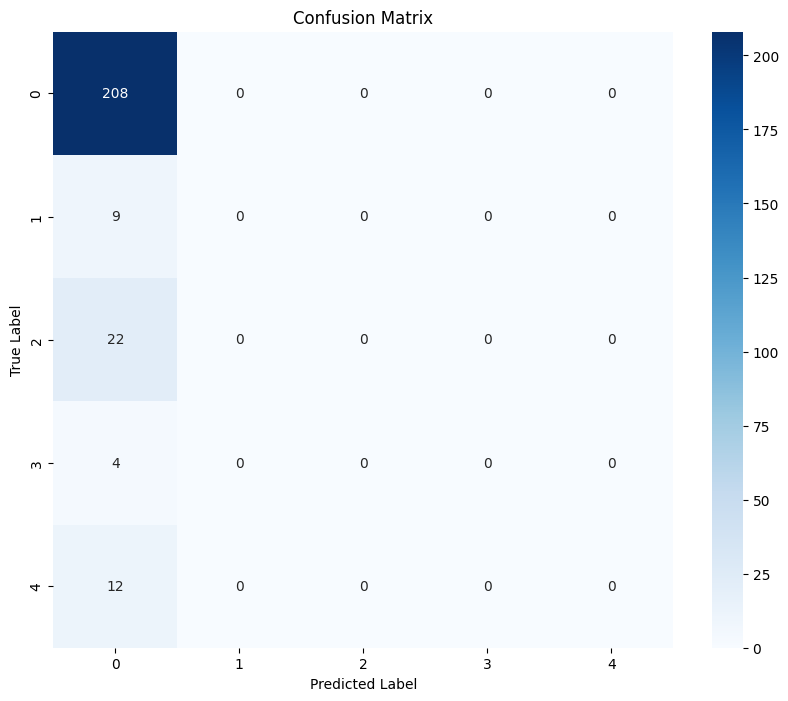

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!tensorboard --logdir=logs/fit



NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.2 at http://localhost:6006/ (Press CTRL+C to quit)
